In [1]:
import pandas as pd
import numpy as np
#import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.vector_ar.vecm import VECM, select_order, select_coint_rank

In [2]:
ntl=pd.read_csv('ntl.csv')
gdp=pd.read_excel('gdp.xlsx')
ntl.Date=pd.to_datetime(ntl['Date'])
ntl['qtr']=ntl['Date'].dt.quarter
ntl['year']=ntl['Date'].dt.year
ntlm=ntl.groupby(['year','qtr'])['NTL_Radiance'].mean().reset_index()
ntlm['Date']=pd.date_range(start='2012-01-01', periods=len(ntlm), freq='QE')
ntlm=ntlm[['Date','NTL_Radiance']]
ntlm['g']=gdp['g']
ntlm['NTL_Radiancelag'] = ntlm['NTL_Radiance'].shift(4)
ntlm['ntlg'] = ((ntlm['NTL_Radiance'] - ntlm['NTL_Radiancelag']) / ntlm['NTL_Radiancelag']) * 100
ntlm=ntlm.dropna().reset_index(drop=True)
ntlm=ntlm.set_index('Date')
ntlm=ntlm[['g','ntlg']]

In [3]:
# Select optimal lag order
lag_order = select_order(ntlm, maxlags=12, deterministic="ci")
print(lag_order.summary())

# Select cointegration rank
coint_rank = select_coint_rank(ntlm, det_order=0, k_ar_diff=lag_order.aic)
print(coint_rank.summary())

 VECM Order Selection (* highlights the minimums) 
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        7.151      7.507*      1278.*      7.274*
1        7.323       7.857       1526.       7.507
2        7.440       8.151       1731.       7.685
3        7.197       8.086       1380.       7.504
4        7.099       8.166       1283.       7.468
5        7.201       8.446       1474.       7.631
6        7.371       8.793       1839.       7.862
7        7.195       8.795       1656.       7.747
8        7.376       9.153       2183.       7.989
9        7.068       9.023       1825.       7.743
10       6.834       8.967       1721.       7.571
11       6.512       8.823       1585.       7.310
12      6.448*       8.937       2085.       7.307
--------------------------------------------------
Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------

c:\Users\PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be use

In [4]:
vecm_model = VECM(ntlm, k_ar_diff=lag_order.bic, coint_rank=coint_rank.rank, deterministic="ci")
vecm_res = vecm_model.fit()

c:\Users\PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)


In [5]:
# In-sample fitted values (starts after initial lags)
fitted_values = vecm_res.fittedvalues
fitted_df = pd.DataFrame(fitted_values, columns=ntlm.columns)
fitted_df.index = pd.date_range(start='2013-03-31', periods=47, freq='QE')
wew=pd.merge(ntlm,fitted_df,left_index=True,right_index=True,suffixes=('','_fitted'))

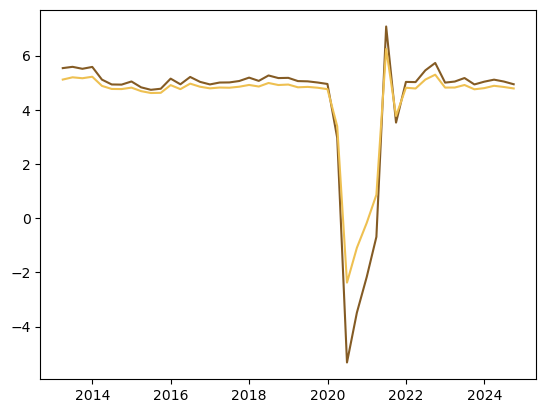

In [ ]:
plt.plot(wew['g'],color='#845B24',label="Actual GDP Growth")
plt.plot(wew['g_fitted'], linestyle='-', color='#EEC051', label="Predicted GDP Growth")
plt.tight_layout()
plt.savefig('growth_nitelite.png')

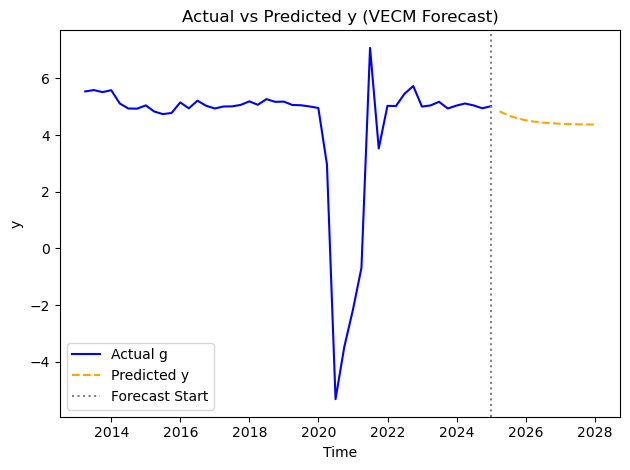

In [ ]:
## Experimental
n_forecast = 12
forecast = vecm_res.predict(steps=n_forecast)
forecast_df = pd.DataFrame(forecast, columns=ntlm.columns)
forecast_df.index = pd.date_range(start=ntlm.index[-1] + pd.offsets.MonthBegin(), periods=n_forecast, freq='QE')

# Plot actual y
plt.plot(ntlm['g'], label='Actual g', color='blue')

# Plot predicted y
plt.plot(forecast_df['g'], label='Predicted y', color='orange', linestyle='--')

# Mark forecast start
plt.axvline(ntlm.index[-1], color='gray', linestyle=':', label='Forecast Start')

# Labels and legend
plt.title('Actual vs Predicted y (VECM Forecast)')
plt.xlabel('Time')
plt.ylabel('y')
plt.legend()
plt.tight_layout()
plt.show()
